<a href="https://colab.research.google.com/github/Irina-64/Deep-Learning-Algorithms/blob/main/%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_(%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0)_%7C_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1geCxDQuvQXiXxE8Zpm1aECLVvONpQ4Ec?usp=sharing&authuser=1#scrollTo=RwRCtThNJ-cS)

2. Практика 





Перейдем к практической части урока по автокодировщикам. Обучим несколько сетей на изображениях рукописных цифр MNIST и исследуем их работу.


In [ ]:
# Импортируем TensorFlow
import tensorflow as tf

# Проверим версию. Работаем на 2х версии
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:
# Импортируем Keras
import keras

# Проверим версию - 2.6.0 актуальная
keras.__version__

'2.6.0'

In [ ]:
# Подключим Numpy
import numpy as np

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Подключим датасет рукописных цифр MNIST
from tensorflow.keras.datasets import mnist

# Импортируем Keras
from tensorflow import keras

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose

# Подключим модуль вычислений на Keras
import keras.backend as K

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

In [ ]:
# Загрузим датасет рукописных цифр
(xs_train, y_train), (xs_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
hidden_dim = 2  # Зададим размерность скрытого пространства AE

batch_size = 60 # Задамим размер батча для обучения AE(должно быть кратно 60 000)

In [ ]:
# Определим функцию отображения результатов работы декодера

def showResult(decoder): # Получим обученный декодер

    n = 5                                                               
    total = 2*n+1                                                     # Считаем полное количесво выводимых цифр +1
    plt.figure(figsize=(total, total))                                # Создаем заготовку для финальной картинки 
    num = 1                                                           # Счетчик выводимых цифр
    for i in range(-n, n+1):                                          # Цикл по горизонтали пространства Z
     for j in range(-n, n+1):                                         # Цикл по вертикали пространства Z
        ax = plt.subplot(total, total, num)                           # Добавим место для графика
        num += 1                                                      # Инкремент номера графика
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0)) # Выполним предикт изображения цифры по точкам из Z области
        plt.imshow(img.squeeze(), cmap='gray')                        # Рисуем предсказанную цифру
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

In [ ]:
# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


In [ ]:
# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x

## AE

### Простой AE

Напишем первый автокодировщик. Он состоит из двух частей – энкодера и декодера. Эти части создаем отдельно, затем из них конструируем AЕ. После обучения их можно будет использовать как вместе, так и раздельно. 

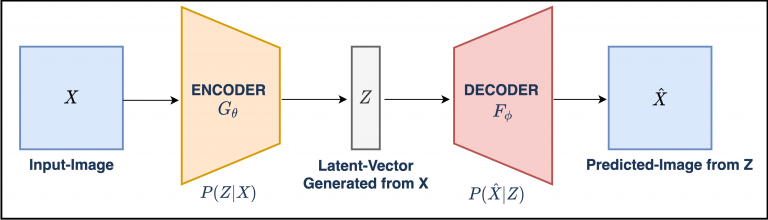

Давайте вспомним, что:
1. `Х` – пространство входных элементов, наш датасет. 
2. `Z` – так называемое скрытое пространство. Это та область, где энкодер отображает входной датасет. 
3. `X'`– это пространство восстановленных изображений. Его декодер создает из точек `Z`. 

В дальнейшей работе мы будем придерживаться именно таких формулировок. 

При изучении AE отдельно создаем нейронную сеть энкодера и отдельно – декодера. Затем собираем из них автокодировщик и обучаем его. При необходимости изучить скрытое пространство  берем обученный энкодер и прогоняем через него входной датасет, смотрим выход.

При необходимости генерировать картинки берем предобученный декодер и подаем ему на вход случайные выборки, смотрим на результаты. Возможно, нам потребуется оценить, как АЕ восстанавливает картинку по готовому образцу. 

Вот и полная модель АЕ!

In [ ]:
# Создадим энкодер

input_img = Input(shape=(28, 28, 1))       # Входной слой, размерность тензора 28х28х1
x = Flatten()(input_img)                   # Преобразуем 3d тензор в 1d размерностью 784
x = Dense(128, activation='relu')(x)       # Первый Dense
x = Dense(64, activation='relu')(x)        # Второй Dense
encoded = Dense(2, activation='linear')(x) # Выходной Dense

In [ ]:
# Создадим декодер

input_enc = Input(shape=(2,))               # Входной слой декодера - размерность 2
d = Dense(64, activation='relu')(input_enc) # Первый Dense 
d = Dense(28*28, activation='sigmoid')(d)   # Первый Dense  - 784 нейрона
decoded = Reshape((28, 28, 1))(d)           # Меняем размерность тензора на 28х28х1 - обратим внимание на размеры тензора на входе энкодера

In [ ]:
# Собираем наши сетки

encoderAE = keras.Model(input_img, encoded, name="encoder")      # Собираем энкодер
decoderAE = keras.Model(input_enc, decoded, name="decoder")      # Собираем декодер

hidden = encoderAE(input_img)                                    # Энкодер отображает входные изображения в точки скрытого пространства
output = decoderAE(hidden)                                       # Декодер восстанавливает изображения  из точек скрытого пространства
autoencoder = keras.Model(input_img, output, name="autoencoder") # Собираем AE 


Сборку автокодировщика можно записать в более компактной форме, без использования промежуточных переменных.


1. Записываем выход АЕ как результат работы декодера: 

        output = decoderAE(hidden) 

2. Декодер принимает на свой вход результат работы энкодера 
        
        hidden = encoderAE(input_img) 

3. Выражение п.2 подставим в выражение п.1. Итого на выходе AE получаем 

        output = decoderAE(encoderAE(input_img)) 

4.  Подставим выражение п.3 в 

        autoencoder = keras.Model(input_img, output, name="autoencoder")

Получаем:

        autoencoder = keras.Model(input_img, decoderAE(encoderAE(input_img)), name="autoencoder") 

Далее будем придерживаться компактной формы записи.

In [ ]:
# Компилируем наш первый AE
autoencoder.compile(optimizer='adam', loss='mean_squared_error') 

In [ ]:
# Выведем состав энкодера
encoderAE.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 108,866
Trainable params: 108,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Выведем состав декодера
decoderAE.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Обучим AE

autoencoder.fit(x_train,          # Обучающая выборка
                x_train,          # "Labels" обучающей выборки
                epochs=10,        # 10 эпох
                batch_size=64,    # размер батча 64
                shuffle=True)     # обучающие выборки перемешиваем 

Epoch 1/10
938/938 [==============================] - 4s 2ms/step - loss: 0.0592
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0490
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0470
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0460
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0452
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0446
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0441
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0436
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0433
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0429


Посмотрим на использование скрытого пространства АЕ. Для этого возьмем ранее 
обученный энкодер и подадим на него некоторое количество изображений цифр. 
Иными словами, отобразим множество точек (векторов) входного пространства во множество точек **скрытого пространства**:

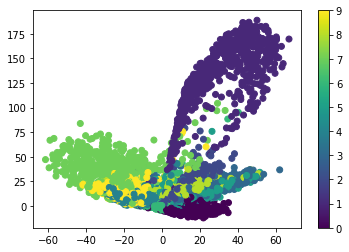

In [ ]:
# Выведем использование скрытого пространства AE

h = encoderAE.predict(x_test[:6000], batch_size=batch_size)     # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[:, 0], h[:, 1] , c=y_test[:6000], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                      # Отрисуем картинку

Повод огорчиться: точки в скрытом пространстве весьма сильно рассеяны. Чем это плохо? Допустим, нам нужно изображение цифры. Генерируем точки в пространстве `Z` и получаем:

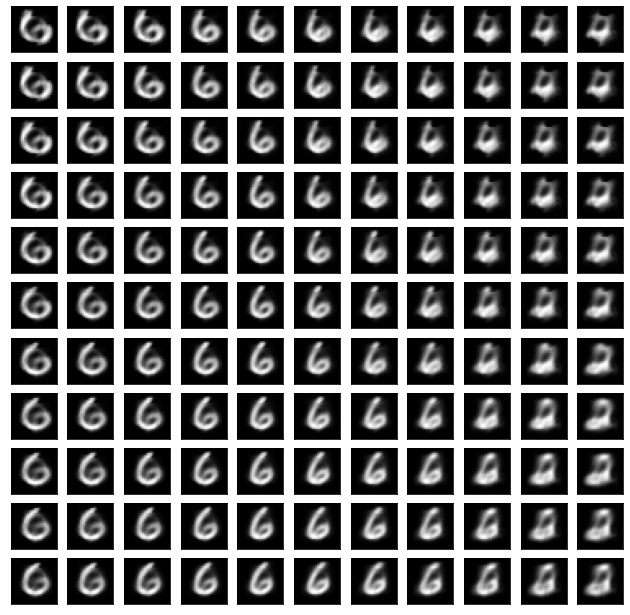

In [ ]:
# Выведем 100 цифр, сгенерированных декодером

showResult(decoderAE) 

Да, получаем много изображений чего-то усредненного по всем изображениям. 
Из 100 попыток ни разу не попали. Мы не можем использовать такой декодер как генератор контента. Просто не попадем в точку, которую знает декодер.

Давайте сделаем АЕ поумнее.

### Сверточный AE

In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
# Создадим сверточный энкодер

input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
x = encoderBlock(input_img, neu=32, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=1)         # Добавим 4-й блок свертка+нормализация+активашка
flatten =Flatten()(x)                                    # Добавим Flatten
encoded = Dense(2, activation='linear')(flatten)         # Добавим выходной dense слой

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=(2,))                            # Добавим входной слой
x = Dense(3136, name='dense_1')(input_enc)               # Добавим dense в 7х7х64 = 3136 нейронами
x = Reshape((7, 7, 64))(x)                               # Решейпим 1D тензор в 3D тензор
x= decoderBlock(x, neu=64, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=64, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=32, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)# Добавим выходной слой

In [ ]:
# Соберем наши нейронки 

encoderAEC = keras.Model(input_img, encoded, name="encoder")                                # Соберем энкодер
decoderAEC = keras.Model(input_enc, decoded, name="decoder")                                # Соберем декодер
autoencoder = keras.Model(input_img, decoderAEC(encoderAEC(input_img)), name="autoencoder") # Соберем автокодировщик
autoencoder.compile(optimizer='adam', loss='mean_squared_error')                            # Скомпилируем автокодировкщик

In [ ]:
# Выведем состав энкодера

encoderAEC.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0   

In [ ]:
# Выведем состав декодера

decoderAEC.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        3692

In [ ]:
# Обучим сверточный автокодировщик

autoencoder.fit(x_train,       # Обучающая выборка
                x_train,       # "Labels" обучающей выборки
                epochs=10,     # 10 эпох
                batch_size=64, # размер батча
                shuffle=True)  # обучающую выборку перемешиваем

Epoch 1/10
938/938 [==============================] - 22s 7ms/step - loss: 0.0523
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0463
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0447
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0437
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0428
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0423
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0418
Epoch 8/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0413
Epoch 9/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0410
Epoch 10/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0408


И вновь смотрим на точки в **скрытом пространстве**:

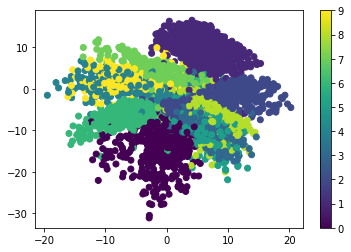

In [ ]:
# Выведем использование скрытого пространства 

h = encoderAEC.predict(x_test[:6000], batch_size=batch_size)     # Предиктим энкодером первые 6000 изображений ифр 
plt.scatter(h[:, 0], h[:, 1] , c=y_test[:6000], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                      # Отрисуем картинку

Уже лучше! Точки менее размазаны по плоскости, есть устойчивые области, где сгруппированы точки одного класса.

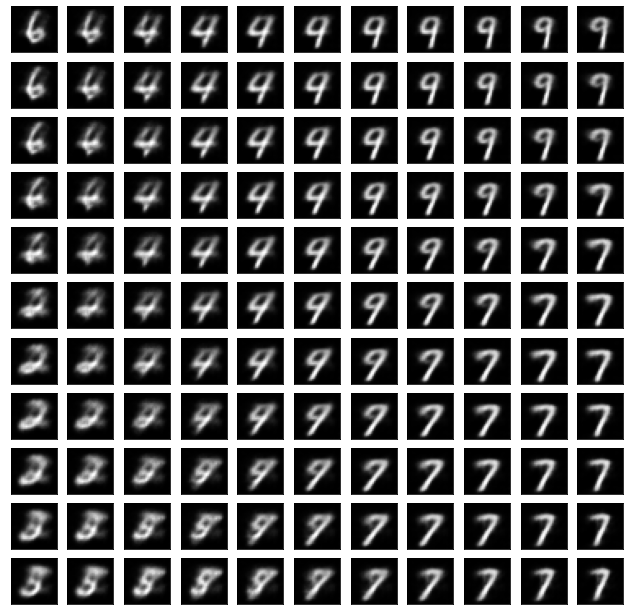

In [ ]:
# Выведем 100 цифр, сгенерированных декодером

showResult(decoderAEC) 

Пробежимся по окрестностям `0,0`. Ситуация более приятная. Цифры начинают различаться. Видно, как изображения одних цифр плавно перетекают в изображения других цифр. Причина тому – более плотная группировка точек. 

Давайте продвинемся еще дальше и вместо точки в скрытом пространстве создадим облачко, а затем потребуем, чтобы AE склеил из них тучку. 

## VAE

### Простой VAE
В сущности VAE – это тот же AE по структуре (энкодер и декодер). Но между ними сделали один слой, который размазывает точки в скрытом пространстве, от чего из точки получается пятно. Кроме того, мы ввели дополнительный лосс, который собирает все пятна вместе. Далее будет понятна реализация этих нововведений.

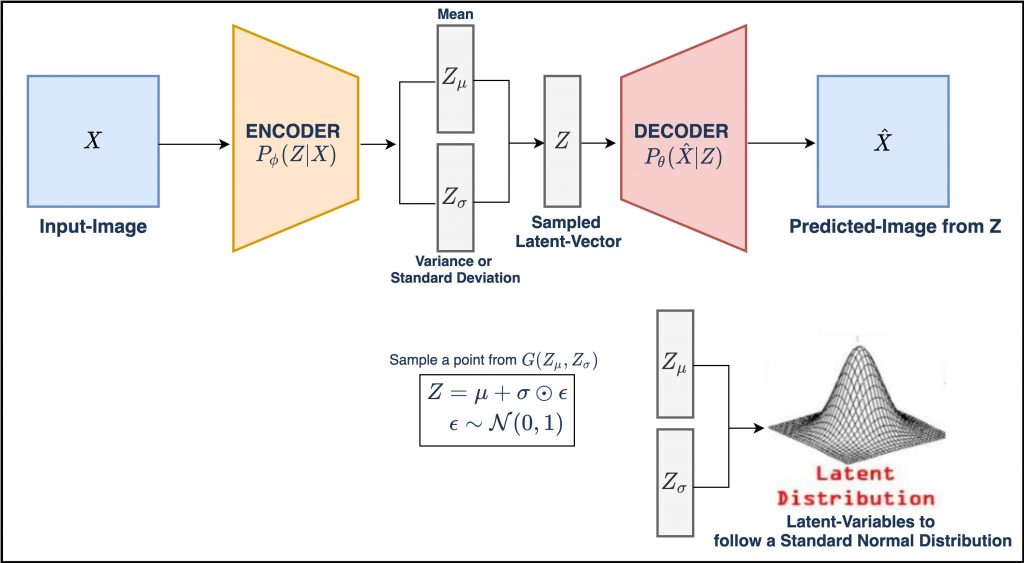 

In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
# Функция создания блока энкодера-декодера

def dropout_and_batch(xin): # xin - входной тензор

  x = BatchNormalization()(xin) # Добавим слой нормализации
  x = Dropout(0.3)(x)           # Добавим дроаут
  
  # Вернем выходной тензор
  return x                      

In [ ]:
#  Создадим энкодер

input_img = Input((28, 28, 1))       # Добавим входной слой
x = Flatten()(input_img)             # Добавим Flatten
x = Dense(256, activation='relu')(x) # Добавим dense на 256 нейронов
x = dropout_and_batch(x)             # Добавим блок дропаут + нормализация
x = Dense(128, activation='relu')(x) # Добавим dense на 128 нейронов
x = dropout_and_batch(x)             # Добавим блок дропаут + нормализация

Выход энкодера подаем сразу, параллельно на два dense-слоя – формирователи мат. ожидания и логарифма дисперсии. Здесь вместо точки в пространстве `Z` формируется облачко:

In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                         # Входные параметры
  z_mean, z_log_var = args                                                # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0)# Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])       # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                          # На выходе - тензор случайных чисел 

In [ ]:
# Соберем энкодер

encoderVAE = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [ ]:
#  Создадим декодер

input_dec = Input(shape=(hidden_dim,))      # Добавим входной слой
d = Dense(128, activation='relu')(input_dec)# Добавим 1й dense
d = dropout_and_batch(d)                    # Добавим 1й блок дропаут+нормализация
d = Dense(256, activation='relu')(d)        # Добавим 2й dense
d = dropout_and_batch(d)                    # Добавим 2й блок дропаут+нормализация
d = Dense(28*28, activation='sigmoid')(d)   # Добавим выходной dense
decoded = Reshape((28, 28, 1))(d)           # Решейпим до исходной размерности картинки


In [ ]:
# Соберем декодер

decoderVAE = keras.Model(input_dec, decoded, name='decoder')               

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAE(encoderVAE(input_img)[2])    # Заметим, что на только 1 из 3х выходов энкодера будем использовать

In [ ]:
# Соберем наши сетки

vae = keras.Model(input_img, outputs, name="vae") 

Функции потерь в `Keras` всегда принимают два параметра `y_true` и `y_pred`. Обратимся к справочнику по Keras. `BinaryCrossentropy`, `MeanSquaredErrory` и  другие - это все функции этих двух параметров, `y_true` и `y_pred`. Это истиннное и предсказанное  моделью значение Y. 

Но некоторые, более сложные потери, не записать таким образом. Для нашего случая, функция потерь зависит от дополнительных тензоров, а именно `z_log_var` и `z_mean`, которые невозможно отдать функции потерь в качестве дополнительных аргументов. 

Самый простой выход - это использование метода `model.add_loss()`. Он  не имеет такого ограничения и позволяет записывать гораздо более сложные функции потерь, которые зависят от многих других тензоров. 

Запишем выражение расчета потерь нашего `VAE`. В нем учтем ошибку восстановления изображения автокодировщиком (`reconstruction_loss`  - функция потерь `MSE`)  и дивергенцию Кульбака - Лейблера - расхождение распределения точек в скрытом пространстве от нормального.

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vae_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
vae.add_loss(vae_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Выведем состав энкодера 

encoderVAE.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      flatten_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 256)          1024        dense_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Выведем состав декодера

decoderVAE.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               384       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0   

In [ ]:
 # Компилируем VAE

vae.compile(optimizer='adam')

In [ ]:
# Запускаем обучениe

vae.fit(x_train,       # Обучающая выборка
        x_train,       # "Labels" обучающей выборки
        epochs=5,      # 10 эпох
        batch_size=60, # размер батча
        shuffle=True)  # обучающую выборку перемешиваем

Epoch 1/5
1000/1000 [==============================] - 5s 4ms/step - loss: 63.1195
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 45.3685
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 44.0325
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/step - loss: 43.2418
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step - loss: 42.7166


Смотрим на точки в **скрытом пространстве**:

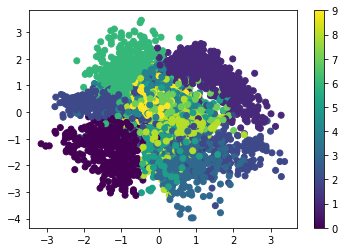

In [ ]:
h = encoderVAE.predict(x_test[:6000], batch_size=batch_size)          # Предиктим энкодером первые 6000 цизображений ифр 

plt.scatter(h[2][:, 0], h[2][:, 1] , c=y_test[:6000], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                        # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                            # Отрисуем картинку

Скрытое пространство стало еще плотнее. Ждем улучшения результатов генерации изображений.

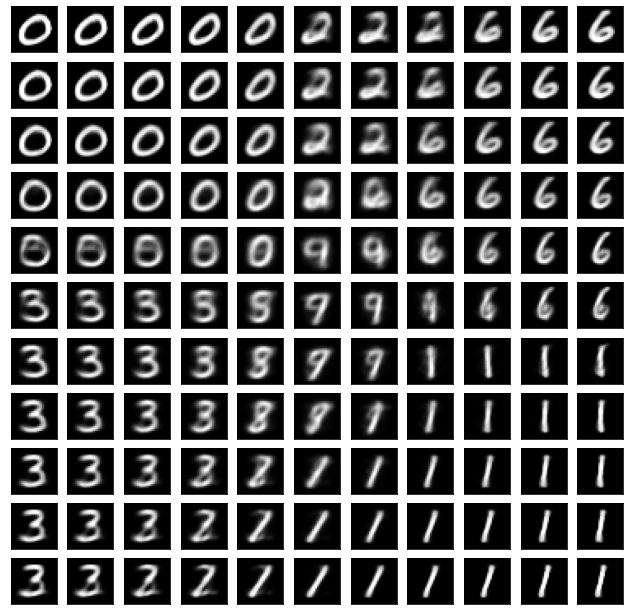

In [ ]:
# Выведем 100 цифр, сгенерированных декодером

showResult(decoderVAE) 

Получили несколько легко узнаваемых изображений цифр. Количество бракованных цифр уменьшается на глазах. Проверим, как себя поведет более умный AE.

### Сверточный VAE


In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
# Создадим сверточный энкодер

input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
x = encoderBlock(input_img, neu=32, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=1)         # Добавим 4-й блок свертка+нормализация+активашка
flatten =Flatten()(x)                                    # Добавим Flatten
x = Dense(2, activation='linear')(flatten)               # Добавим выходной dense слой

In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                           # На выходе - тензор случайных чисел 

In [ ]:
 # Соберем энкодер

encoderVAEС = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=(2,))                            # Добавим входной слой
x = Dense(3136, name='dense_1')(input_enc)               # Добавим dense в 7х7х64 = 3136 нейронами
x = Reshape((7, 7, 64))(x)                               # Решейпим 1D тензор в 3D тензор
x= decoderBlock(x, neu=64, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=64, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=32, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)# Добавим выходной слой

In [ ]:
# Соберем декодер

decoderVAEС = keras.Model(input_enc, decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAEС(encoderVAEС(input_img)[2]) 

In [ ]:
# Соберем наши сетки

vaec = keras.Model(input_img, decoderVAEС(encoderVAEС(input_img)[2])) # Соберем VAE

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
vaec.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Выведем состав энкодера
encoderVAEС.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 28, 28, 32)   128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [ ]:
#  Выведем состав энкодера
decoderVAEС.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 64)        3692

In [ ]:
# Компилируем VAE

vaec.compile(optimizer='adam') # оптимайзер ADAM

In [ ]:
# Запускаем обучениe

vaec.fit(x_train,      # Обучающая выборка
        x_train,       # "Labels" обучающей выборки
        epochs=5,      # 10 эпох
        batch_size=60, # размер батча
        shuffle=True)  # обучающую выборку перемешиваем


Epoch 1/5
1000/1000 [==============================] - 12s 11ms/step - loss: 47.1253
Epoch 2/5
1000/1000 [==============================] - 10s 10ms/step - loss: 43.3141
Epoch 3/5
1000/1000 [==============================] - 10s 10ms/step - loss: 42.1747
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/step - loss: 41.3316
Epoch 5/5
1000/1000 [==============================] - 10s 10ms/step - loss: 40.7847


Смотрим на точки в **скрытом пространстве**:

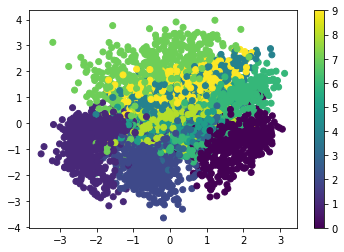

In [ ]:
h = encoderVAEС.predict(x_test[:6000], batch_size=batch_size)    # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[2][:, 0], h[2][:, 1] , c=y_test[:6000], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                      # Отрисуем картинку

Получили более компактное использование скрытого пространства.
Изображения цифр еще лучше.

Генерация цифр – это хорошо, но ведь есть много других задач для AE. И везде важно скрытое пространство, поскольку оно показывает качество работы нашего AE. Можно с уверенностью ожидать, что в задачах восстановления изображения, шумоподавления AE с непрерывной зоной использования скрытого пространства покажет лучшие результаты.

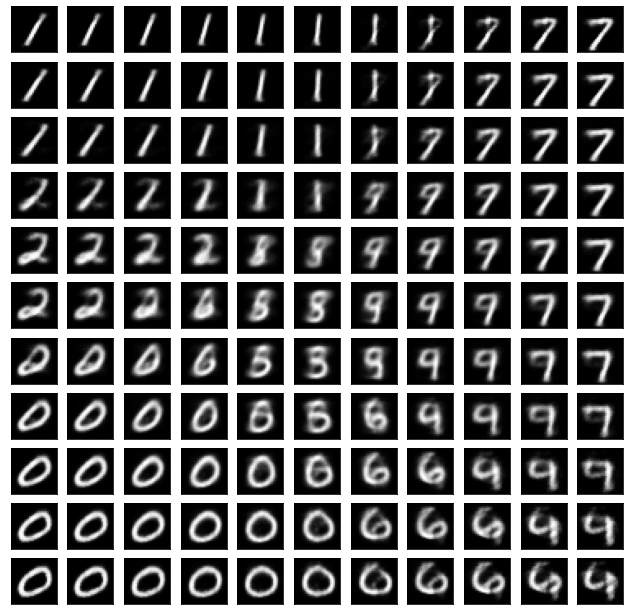

In [ ]:
# Выведем 100 цифр, сгенерированных декодером

showResult(decoderVAEС)

## CVAE

### Простой CVAE

VAE с условием (CVAE) – это наш знакомый VAE, только на энкодер и декодер которых дополнительно подают метки классов объектов (изображений). Довольно сложно определить, куда и в каком виде подавать метки. Это зависит от формата данных в нашем датасете, типов энкодера и декодера. В одном случае метки класса будут поданы на вход, в другом – на промежуточные слои. В одном случае метки будут в виде OHE, в другом – 2D векторы. Вариантов весьма много.

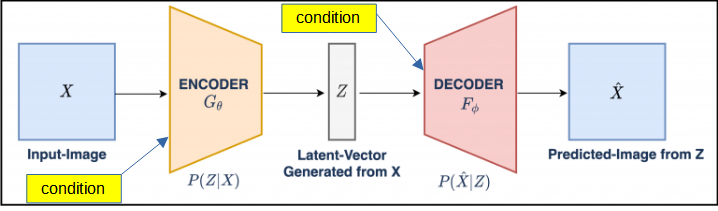

In [ ]:
hidden_dim = 2
num_classes = 10
batch_size = 100  # должно быть кратно 60 000 и 10 0000

In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Создадим простой энкодер

input_img = Input((28, 28, 1))       # Добавим входной слой
fl = Flatten()(input_img)             # Добавим Flatten
lb = Input(shape=(num_classes,))     # Добавим входной слой для метки класса
x = concatenate([fl, lb])            # конкатенируем метку класса изображение
x = Dense(256, activation='relu')(x) # Добавим dense на 256 нейронов
x = dropout_and_batch(x)             # Добавим блок дропаут + нормализация
x = Dense(128, activation='relu')(x) # Добавим dense на 128 нейронов
x = dropout_and_batch(x)             # Добавим блок дропаут + нормализация

In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
                                                                           # Эти "псевдовыходы" энкодера  потребуются для расчета потерь
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                           # На выходе - тензор случайных чисел 

In [ ]:
# Соберем энкодер

encoderCVAE = keras.Model([input_img, lb], [z_mean, z_log_var, h], name='encoder')

In [ ]:
#  Создадим декодер

input_dec = Input(shape=(hidden_dim,))      # Добавим входной слой
lb_dec = Input(shape=(num_classes,))        # Добавим вход для метки класса
d = concatenate([input_dec, lb_dec])        # Конкатенируем метку класса и вектор скрытого пространства
d = Dense(128, activation='relu')(d)        # Добавим 1й dense
d = dropout_and_batch(d)                    # Добавим 1й блок дропаут+нормализация
d = Dense(256, activation='relu')(d)        # Добавим 2й dense
d = dropout_and_batch(d)                    # Добавим 2й блок дропаут+нормализация
d = Dense(28*28, activation='sigmoid')(d)   # Добавим выходной dense
decoded = Reshape((28, 28, 1))(d)           # Решейпим до исходной размерности картинки

In [ ]:
# Соберем декодер

decoderCVAE = keras.Model([input_dec, lb_dec], decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderCVAE([encoderCVAE([input_img, lb])[2], lb_dec])

In [ ]:
#Соберем наши CVAE
cvae = keras.Model([input_img, lb, lb_dec], outputs , name="cvae") # Соберем VAE

# Соберем вспомогательную модель
z_meaner = keras.Model([input_img, lb], z_mean)   

# Соберем модель для переноса стиля
tr_style = keras.Model([input_img, lb, lb_dec], decoderCVAE([z_meaner([input_img, lb]), lb_dec]), name='tr_style') 

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
cvae_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)     # Суммируем лоссы - здесь можно вводить веса  
cvae.add_loss(cvae_loss)                                       # Отдадим наш лосс VAE

In [ ]:
# Проверим состав энкодера

encoderCVAE.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           flatten_4[0][0]                  
                                                                 input_11[0][0]             

In [ ]:
# Проверим состав декодера

decoderCVAE.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 128)          384         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 128)          512         dense_20[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 128)          0           batch_normalization_23[0][0]     
____________________________________________________________________________________________

In [ ]:
# Компилируем VAE

cvae.compile(optimizer='adam') # оптимайзер ADAM

In [ ]:
# Обучим модель

cvae.fit([x_train, y_train_cat, y_train_cat],  # Обучающая выборка + метки классов для энкодера и декодера
         x_train,                              # Обучающая выборка
         epochs=5,                             # Число эпох
         batch_size=batch_size,                # Размер батча
         shuffle=True)                         # Обучающую выборку перемешиваем

Epoch 1/5
600/600 [==============================] - 3s 4ms/step - loss: 77.7160
Epoch 2/5
600/600 [==============================] - 2s 4ms/step - loss: 48.6793
Epoch 3/5
600/600 [==============================] - 2s 4ms/step - loss: 45.9657
Epoch 4/5
600/600 [==============================] - 2s 4ms/step - loss: 44.5907
Epoch 5/5
600/600 [==============================] - 2s 4ms/step - loss: 43.7603


Смотрим на точки в **скрытом пространстве**:

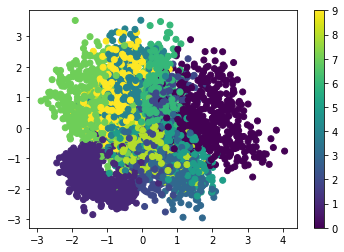

In [ ]:
lb = lb_dec = y_test_cat                                                   # Копия меток классов
h = encoderCVAE.predict([x_test[:6000], lb[:6000]], batch_size=batch_size) # Предиктим точки скрытого пространства с учетом меток

plt.scatter(h[2][:, 0], h[2][:, 1] , c=y_test[:6000], cmap='viridis')        # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                               # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                                   # Отрисуем картинку

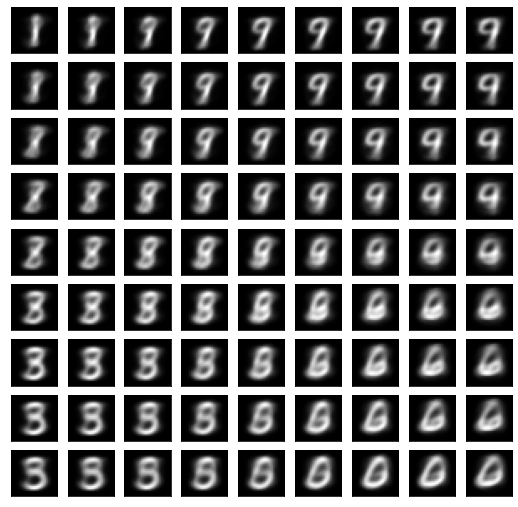

In [ ]:
# Генерим разные пятерки

n = 4                                      # Просто нужная переменная
total = 2*n+1                              # Считаем общий размер картинки
input_lbl = np.zeros((1, num_classes))     # Заготовим массов из нулей, размерности = числу классов
input_lbl[0, 5] = 1                        # В пятый элемент запишем 1
plt.figure(figsize=(total, total))         # Заготовим общую картинку
h = np.zeros((1, hidden_dim))              # Заготовим массов из нулей, размерности = скрытого пространства
num = 1                                    # Создаем счетчик картинок

for i in range(-n, n+1):                   # Цикл по горизонтали
  for j in range(-n, n+1):                 # Цикл по вертикали
    ax = plt.subplot(total, total, num)    # Заготовим отдельную картинку для цифры
    num += 1                               # Инкрементируем счетчик картинок
    h[0, :] = [1*i/n, 1*j/n]               # Создадим точку из скрытого пространство
    img = decoderCVAE.predict([h, input_lbl])  # Предиктим цифру 5,  соответсвующую точке скрытого пространства
    plt.imshow(img.squeeze(), cmap='gray') # Отрисуем полученную цифру
    ax.get_xaxis().set_visible(False)      # Уберем ось X
    ax.get_yaxis().set_visible(False)      # Уберем ось Y

In [ ]:
# Создадим функцию для отрисовки линейки картинок

def plot_digits(*images): # Список картинок

    images = [x.squeeze() for x in images]               # Понизим размерности картинок
    n = min([x.shape[0] for x in images])                # Найдем число картинок
    plt.figure(figsize=(n, len(images)))                 # Заготовим общее изображение
    for j in range(n):                                   # Цикл по 
        for i in range(len(images)):                     # Цикл по списку картинок
            ax = plt.subplot(len(images), n, i*n + j + 1)# Заготовим картинку
            plt.imshow(images[i][j])                     # Отрисуем ее
            plt.gray()                                   # Рисуем в градациях серого 
            ax.get_xaxis().set_visible(False)            # Уберем ось X
            ax.get_yaxis().set_visible(False)            # Уберем ось Y

    plt.show()                                           # Отрисуем итоговую картиную

Выполним перенос стиля. Источник стиля – десять экземпляров одной цифры.

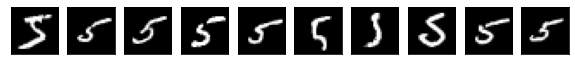

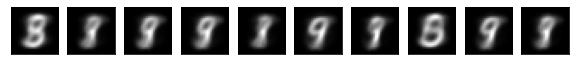

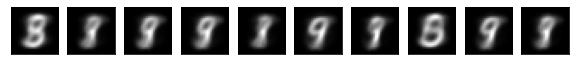

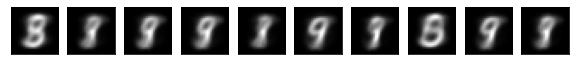

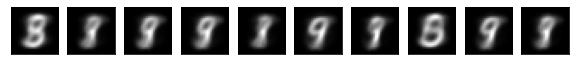

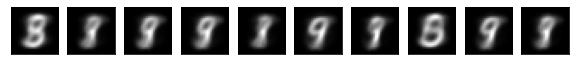

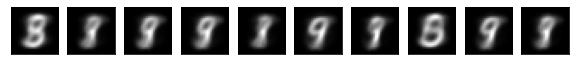

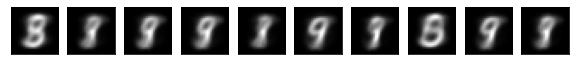

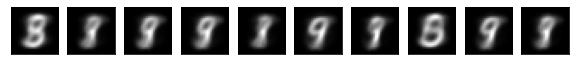

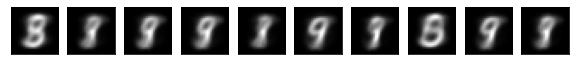

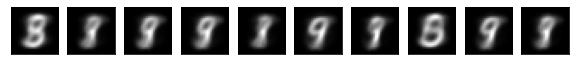

In [ ]:
# Выберем цифры - источник
dig1 = 5

# Выберем число образцов
num = 10

# Отберем образцы стилей
X = x_train[y_train == dig1][:num]

# Создадим массив из нулей
lb_1 = np.zeros((num, num_classes))

# Заполним 5-ю колонку единицами
lb_1[:, dig1] = 1

# Отрисуем образцы стилей
plot_digits(X)

# Цикл по всем возможным классам цифр
for i in range(num_classes):

  lb_2 = np.zeros((num, num_classes)) # Создадим массив из нулей
  lb_2[:, i] = 1                      # Заполним i-ю колонку единицами

  Y = tr_style.predict([X, lb_1, lb_2], batch_size=num) # Выполним предикт 
  plot_digits(Y)                                        # Отрисуем полученные цифры

###Сверточный CVAE

In [ ]:
hidden_dim = 2
num_classes = 10
batch_size = 100  # должно быть кратно 60 000 и 10 0000

In [ ]:
# Нормализация, приведем массивы пикселей к диапазону 0...1 для обучающей выборки
x_train = xs_train / 255. 
x_test = xs_test / 255.   

# Добавим 1 размерность numpy-массиву обучающей выборки
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)   # Метки обучающей выборка перегоним в one-hot encoding
y_test_cat = keras.utils.to_categorical(y_test, num_classes)     # Метки тестовой выборка перегоним в one-hot encoding

In [ ]:
# Создадим сверточный энкодер

input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
x = encoderBlock(input_img, neu=32, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=1)         # Добавим 4-й блок свертка+нормализация+активашка
flatten =Flatten()(x)                                    # Добавим Flatten
lb = Input(shape=(num_classes,))                         # Добавим вход для метки класса
x = concatenate([flatten, lb])                           # Конкатенируем метку класса с выходом flatten
x = Dense(2, activation='linear')(x)               # Добавим выходной dense слой

In [ ]:
z_mean = Dense(hidden_dim)(x)       # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)    # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])       # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                          # На выходе - тензор случайных чисел

In [ ]:
 # Соберем энкодер

encoderCVAEC = keras.Model([input_img, lb], [z_mean, z_log_var, h], name='encoder')

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=(2,))                            # Добавим входной слой
lb_dec = Input(shape=(num_classes,))                     # Добавим вход для метки класса
d = concatenate([input_dec, lb_dec])                     # Конкатенируем метку класса и вектор скрытого пространства
x = Dense(3136, name='dense_1')(d)                       # Добавим dense в 7х7х64 = 3136 нейронами
x = Reshape((7, 7, 64))(x)                               # Решейпим 1D тензор в 3D тензор
x= decoderBlock(x, neu=64, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=64, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=32, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)# Добавим выходной слой

In [ ]:
# Соберем декодер

decoderCVAEC = keras.Model([input_dec, lb_dec], decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderCVAEC([encoderCVAEC([input_img, lb])[2], lb_dec])

In [ ]:
#Соберем наши сетки
cvaec = keras.Model([input_img, lb, lb_dec], outputs, name="cvae") # Соберем VAE

# Соберем вспомогательную модель
z_meaner = keras.Model([input_img, lb], z_mean)       

# Соберем модель для переноса стиля
tr_style = keras.Model([input_img, lb, lb_dec], decoderCVAEC([z_meaner([input_img, lb]), lb_dec]), name='tr_style') 

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
cvaec_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
cvaec.add_loss(cvaec_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Компилируем СVAE

cvaec.compile(optimizer='adam') # оптимайзер ADAM

In [ ]:
# Обучим модель

cvaec.fit([x_train, y_train_cat, y_train_cat], # Обучающая выборка + метки классов для энкодера и декодера
         x_train,                              # Обучающая выборка
         epochs=5,                             # Число эпох
         batch_size=batch_size,                # Размер батча
         shuffle=True)                         # Обучающую выборку перемешиваем


Epoch 1/5
600/600 [==============================] - 8s 12ms/step - loss: 38.6246
Epoch 2/5
600/600 [==============================] - 7s 12ms/step - loss: 34.0573
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 33.0601
Epoch 4/5
600/600 [==============================] - 7s 12ms/step - loss: 32.5373
Epoch 5/5
600/600 [==============================] - 7s 12ms/step - loss: 32.1395


Смотрим на точки в **скрытом пространстве**:

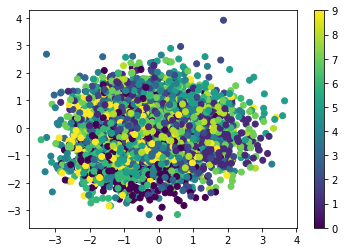

In [ ]:
lb = lb_dec = y_test_cat                                                    # Копия меток классов
h = encoderCVAEC.predict([x_test[:6000], lb[:6000]], batch_size=batch_size) # Предиктим точки скрытого пространства с учетом меток

plt.scatter(h[2][:, 0], h[2][:, 1] , c=y_test[:6000], cmap='viridis')  # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                         # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                             # Отрисуем картинку

А вот – скрытое пространство CVAE. Можно огорчиться: в нем перепутаны все классы. Но, во-первых, мы не требовали от автокодировщика группировки точек по классам. Во-вторых, это и не нужно. Мы указываем декодеру метку класса – того, что мы от него ждем.

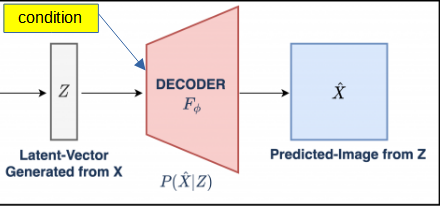

Берем метку класса, генерируем случайные векторы и подаем на декодер. Получаем изображения нужной цифры в разных стилях.

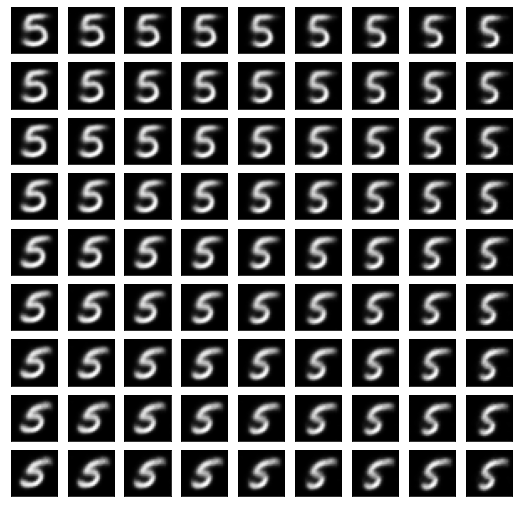

In [ ]:
# Генерим разные пятерки

n = 4                                      # Просто нужная переменная
total = 2*n+1                              # Считаем общий размер картинки
input_lbl = np.zeros((1, num_classes))     # Заготовим массов из нулей, размерности = числу классов
input_lbl[0, 5] = 1                        # В пятый элемент запишем 1
plt.figure(figsize=(total, total))         # Заготовим общую картинку
h = np.zeros((1, hidden_dim))              # Заготовим массов из нулей, размерности = скрытого пространства
num = 1                                    # Создаем счетчик картинок

for i in range(-n, n+1):                   # Цикл по горизонтали
  for j in range(-n, n+1):                 # Цикл по вертикали
    ax = plt.subplot(total, total, num)    # Заготовим отдельную картинку для цифры
    num += 1                               # Инкрементируем счетчик картинок
    h[0, :] = [1*i/n, 1*j/n]               # Создадим точку из скрытого пространство
    img = decoderCVAEC.predict([h, input_lbl])  # Предиктим цифру 5,  соответсвующую точке скрытого пространства
    plt.imshow(img.squeeze(), cmap='gray') # Отрисуем полученную цифру
    ax.get_xaxis().set_visible(False)      # Уберем ось X
    ax.get_yaxis().set_visible(False)      # Уберем ось Y

Посмотрим на перенос стиля. Используя набор изображений цифры 5 как источник стиля, получим от декодера изображения цифр 0,1... 9 в разных стилях:

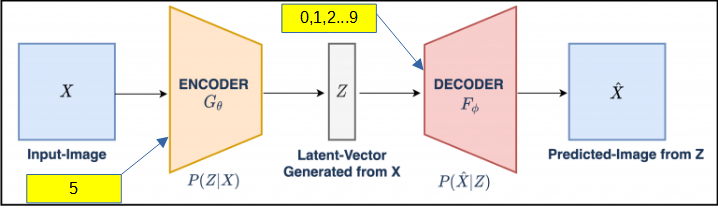

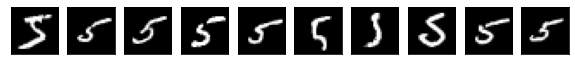

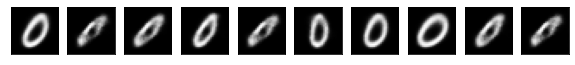

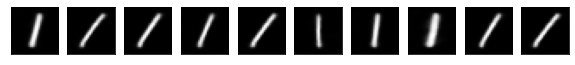

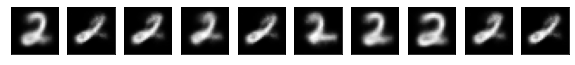

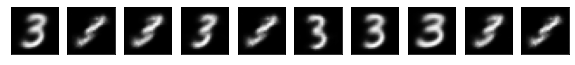

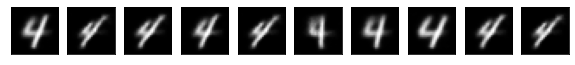

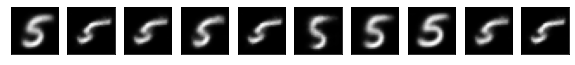

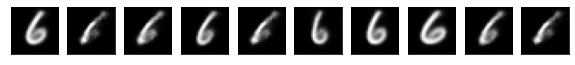

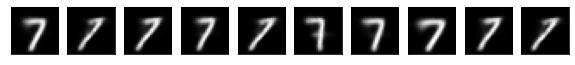

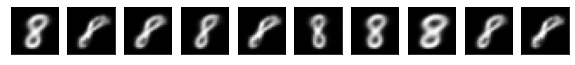

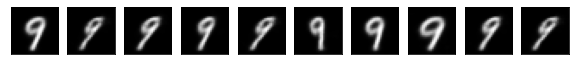

In [ ]:
# Выберем цифры - источник
dig1 = 5

# Выберем число образцов
num = 10

# Отберем образцы стилей
X = x_train[y_train == dig1][:num]

# Создадим массив из нулей
lb_1 = np.zeros((num, num_classes))

# Заполним 5-ю колонку единицами
lb_1[:, dig1] = 1

# Отрисуем образцы стилей
plot_digits(X)

# Цикл по всем возможным классам цифр
for i in range(num_classes):

  lb_2 = np.zeros((num, num_classes)) # Создадим массив из нулей
  lb_2[:, i] = 1                      # Заполним i-ю колонку единицами

  Y = tr_style.predict([X, lb_1, lb_2], batch_size=num) # Выполним предикт 
  plot_digits(Y)                                        # Отрисуем полученные цифру

## Напишем VAE с применением ООП

Нам необходимо оформить VAE как самостоятельный класс. 
Такой шаг весьма полезен, если нужно перенести VAE из одного приложения в другое. Поместим в класс все необходимые переменные и методы. А затем просто создадим экземпляр этого класса. 

AE готов к обучению и работе!

In [ ]:
from tensorflow.keras import layers

# Созданим класс для генерации случайных чисел Sampling

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):               # На входе мат ожидание и дисперсия
        z_mean, z_log_var = inputs        # Разделим вход на 2 параметра
        batch = tf.shape(z_mean)[0]       # Найдем размер батча
        dim = tf.shape(z_mean)[1]         # Найдем размер элемента

        # Создадим тензор из нормальных случайных чисел параметрами (0,1)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        #Создадим и вернем тензор в нужныммат.ожиданием и дисперсией
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Создадим энкодер

latent_dim = 2 #

encoder_inputs = keras.Input(shape=(28, 28, 1))                                       # Добавим входной слой
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)# Добавим сверточный слой
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)             # Добавим сверточный слой
x = layers.Flatten()(x)                                                               # Добавим Flatten
x = layers.Dense(16, activation="relu")(x)                                            # Добавим dense 
z_mean = layers.Dense(latent_dim, name="z_mean")(x)                                   # Добавим dense для формирования мат.ожидания
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)                             # Добавим dense для формирования логарифма дисперсии
z = Sampling()([z_mean, z_log_var])                                                   # Добавим слой генерации случайных чисел
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")         # Соберем модель энкодера
encoder.summary()                                                                     # Выведем состав энкодера

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   320         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 3136)         0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Создадим энкодер

latent_inputs = keras.Input(shape=(latent_dim,))                                        # Добавим входной слой
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)                          # Добавим dense
x = layers.Reshape((7, 7, 64))(x)                                                       # Выполним решейп до размерности 7х7х64
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)      # Добавим обратную свертку
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)      # Добавим обратную свертку
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # Добавим обратную свертку
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")                   # Соберем декодер
decoder.summary()                                                                       # Выведем состав декодера

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [ ]:
# Создадим класс вариационного автокодировщика

class VAE(keras.Model):
    
    # конcтруктор класса
    def __init__(self, encoder, decoder, **kwargs): # Подаем скомпилирование энкодер и декодер
        super(VAE, self).__init__(**kwargs)         # Инициализируем класс - предок
        self.encoder = encoder                      # Заполняем поле encoder
        self.decoder = decoder                      # Заполняем поле encoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") #Указываем лоссы для total_loss_tracker
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"               
        )                                            #Указываем лоссы для reconstruction_loss_tracker
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") #Указываем лоссы для вычисления дивергенции  Кульбака-Лейблера

    # Определяем метод metrics
    @property
    def metrics(self):                              

        # Вернем список лоссов
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Создадим метод train_step
    def train_step(self, data):   

        # Создаем ленту градиентов
        with tf.GradientTape() as tape:  

            # Получим выход энкодера - точка в скрытом слое
            z_mean, z_log_var, z = self.encoder(data)  

            # Получим восстановленное изображение
            reconstruction = self.decoder(z)

            # Вычислим ошибку восстановления изображения
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # Вычислим ошибку Кульбака - Лейблера
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Вычислим суммарную ошибку на шаге
            total_loss = reconstruction_loss + kl_loss

        # Рассчитаем градиенты    
        grads = tape.gradient(total_loss, self.trainable_weights)

        # Корректируем веса модели
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Пересчитаем общий лосс
        self.total_loss_tracker.update_state(total_loss)

        # Пересчитаем лосс восстановления изображеня
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        # Пересчитаем лосс Кульбака-Лейблера
        self.kl_loss_tracker.update_state(kl_loss)

        # Вернем словарь значений лоссов
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Объединяем обучающую и тестовую выборки - просто обучимся на всем датасете
mnist_digits = np.concatenate([xs_train, xs_test], axis=0) # Объединяем обучающую и тестовую выборки

# Добавляем размерность к массиву цифр, приводим к диапазону [0...1]
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255 

# Создаем экземпляр класса автокодировщика
vae = VAE(encoder,  # Собранный энкодер
          decoder)  # Собранный декодер

# Компилируем модель
vae.compile(optimizer=keras.optimizers.Adam()) 

# Обучаем автокодировщик
vae.fit(mnist_digits,   # Обучающая выборка
        epochs=5,       # Число эпох
        batch_size=128) # Размер батча

Epoch 1/5
547/547 [==============================] - 4s 6ms/step - loss: 258.2034 - reconstruction_loss: 205.1458 - kl_loss: 4.1315
Epoch 2/5
547/547 [==============================] - 3s 6ms/step - loss: 175.3530 - reconstruction_loss: 166.7352 - kl_loss: 5.7186
Epoch 3/5
547/547 [==============================] - 3s 6ms/step - loss: 166.7936 - reconstruction_loss: 159.7376 - kl_loss: 5.8946
Epoch 4/5
547/547 [==============================] - 3s 6ms/step - loss: 162.2920 - reconstruction_loss: 155.4404 - kl_loss: 6.1694
Epoch 5/5
547/547 [==============================] - 3s 6ms/step - loss: 159.7792 - reconstruction_loss: 153.2507 - kl_loss: 6.3012


Смотрим на точки в **скрытом пространстве**:

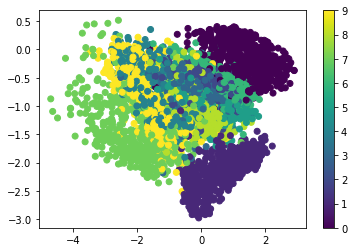

In [ ]:
# Выведем скрытое пространство VAE

h,_,_ = vae.encoder.predict(x_train[:6000], batch_size=batch_size)  # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[:, 0], h[:, 1] , c=y_train[:6000], cmap='viridis')    # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                      # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                          # Отрисуем картинку  

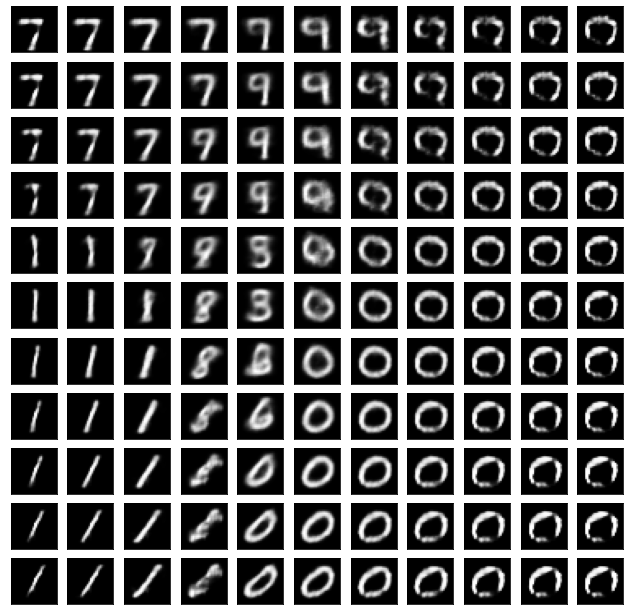

In [ ]:
# Выведем 100 цифр, сгенерированных декодером

showResult(vae.decoder)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1geCxDQuvQXiXxE8Zpm1aECLVvONpQ4Ec?usp=sharing&authuser=1#scrollTo=RwRCtThNJ-cS)

2. Практика 



